# Autoencoder

Set some global parameters

In [58]:
# Whether to rotate data in an orientation indiepndent manner.
# Default: True
USE_ORIENTATION_INDIPENDENT_TRANSFORMATION = True

# Whether to normalize data.
# Note: we usually do not normalize beacause the distance between points
# and reconstructed points gets reduced but the signal is not well represented
# Default: False
USE_NORMALIZATION = False

# Whether to center accelerometer data.
# Note: we tryed centering accelerometer data to check autoencoder behaviour with CNN center data.
# Default: False
USE_CENTERING_ACC = False

# Whether to use Bryan dataset as validation dataset.
# Default: False
USE_BRYAN_VALIDATION_DATASET = True

# Whether to use all positions (right, left, back, top, hand, pocket) from Bryan dataset.
# Default: Flase
USE_ALL_POSITION_BRYAN_DATASET = False

# Whether to use grid search for hyperparameters.
# Note: this task is resource intensive and could take a while. Keep it disabled for prototyping.
# Default: True
USE_GRID_SEARCH = True

# Whether to test some of the best models obtained by grid search.
# Default: True
USE_GRID_SEARCH_VALIDATION = True

In [2]:
def get_settings():
    """
    Return a string which encodes current global settings.
    Can be used as name of files.
    """
    oit = "_oit" if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION else ""
    norm = "_norm" if USE_NORMALIZATION else ""
    bryan = "_bryan" if USE_BRYAN_VALIDATION_DATASET else ""
    allpos = "_allpos" if USE_BRYAN_VALIDATION_DATASET and USE_ALL_POSITION_BRYAN_DATASET else ""
    return oit + norm + bryan + allpos

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers

from autoencoder_utils import show_samples, show_loss, show_mse, show_reconstructed_signals, show_reconstruction_errors
from keras_utils import ModelSaveCallback
from orientation_indipendend_transformation import orientation_independent_transformation

In [4]:
random.seed(42)
np.random.seed(42)

## Load dataset

In [5]:
def load_dataset(data_filename="dataset.csv", label_filename="labels.csv", dataset_dir="./datasets"):
    data = pd.read_csv(os.path.join(dataset_dir, data_filename), header=None, names=range(750))
    labels = pd.read_csv(os.path.join(dataset_dir, label_filename), header=None, names=["user", "model", "label"])

    return data, labels

In [6]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [7]:
X_df_reference, y_df_reference = load_dataset("dataset_50_2.5.csv", "dataset_labels_50_2.5.csv", dataset_dir="./datasets/our2")
X_df_reference_validation, y_df_reference_validation = pd.read_csv("./datasets/bryan/dataset_50_2.5.csv", header=None, names=range(750)), pd.read_csv("./datasets/bryan/dataset_labels_50_2.5.csv", header=None, names=["user", "model", "label", "position"]),

In [8]:
print_stats(X_df_reference)
print_stats(y_df_reference)
print_stats(X_df_reference_validation)
print_stats(y_df_reference_validation)

Shape (22589, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (22589, 3)
Columns Index(['user', 'model', 'label'], dtype='object')
Shape (4790, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (4790, 4)
Columns Index(['user', 'model', 'label', 'position'], dtype='object')


## Preprocessing

In [9]:
def get_label(x):
    return x[2]

In [10]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [11]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

### Training Set

In [12]:
X_df, y_df = X_df_reference.copy(), y_df_reference.copy()

In [13]:

# *** MERGE LABELS
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
#stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
#y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# *** SHUFFLE
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# *** TRAIN AND TEST
if USE_BRYAN_VALIDATION_DATASET:
    but_last_user_indicies = ~(y_df['user'] == "z")
else:
    but_last_user_indicies = ~((y_df['user'] == "a") | (y_df['user'] == "b"))

X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"


X_train_df = 22589
X_test_df = 0
y_train_df = 22589
y_test_df = 0


In [14]:
# 1. Back to numpy
X_train = X_train_df.loc[:].to_numpy()
X_test = X_test_df.loc[:].to_numpy()

# 2. Restructure the array
X_train = restructure(X_train)
X_test = restructure(X_test)

# 3. Normalize
if USE_NORMALIZATION:
    X_train = normalize(X_train)
    X_test = normalize(X_test)
    
# 4. Orientation indipendent transformation
if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION:
    X_train = orientation_independent_transformation(X_train)
    X_test = orientation_independent_transformation(X_test)

# 4. Center accelerometer data
if USE_CENTERING_ACC:
    means = np.mean(X_train, axis=2)
    means[:, 3:] = 0  # do not center gyroscope
    X_train = (X_train - means[:,:,np.newaxis])

    if (len(X_test) > 0):
        means = np.mean(X_test, axis=2)
        means[:, 3:] = 0  # do not center gyroscope
        X_test = (X_test - means[:,:,np.newaxis])

# 5. Get ground thruth
y_train = y_train_df.loc[:].to_numpy()
y_test = y_test_df.loc[:].to_numpy()

# 6. One hot (for classification)
y_train_hot = pd.get_dummies(y_train_df['label']).to_numpy()
y_test_hot = pd.get_dummies(y_test_df['label']).to_numpy()

# 7. Keep only label
y_train = np.array(list(map(get_label, y_train)))
y_test = np.array(list(map(get_label, y_test)))

: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value enc

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22589, 6, 125)
(22589,)
(0,)
(0,)


Labels

In [16]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes = {classes}")
print(f"Num classes = {num_classes}")

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']
Num classes = 5


Plot some samples

X[0]: bike


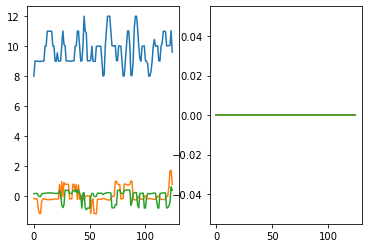

In [17]:
show_samples(X_train, y_train, n=1, is_random=False)

### Validation Set

In [18]:
X_df, y_df = X_df_reference_validation.copy(), y_df_reference_validation.copy()

# Keep valid positions only
if USE_ALL_POSITION_BRYAN_DATASET:
    valid_positions_indicies = ~(y_df["position"] == "none") 
else:
    valid_positions_indicies = (y_df["position"] == "right") | (y_df["position"] == "left") | (y_df["position"] == "top") | (y_df["position"] == "back") | (y_df["position"] == "bottom")

# Filter out other data
X_df = X_df.loc[valid_positions_indicies]
y_df = y_df.loc[valid_positions_indicies]

# Shuffle data
X_df = X_df.sample(frac=1)
y_df = y_df.reindex(X_df.index)

# Back to numpy arrays
X_validation = restructure(X_df.loc[:].to_numpy())
y_validation = y_df["label"].loc[:].to_numpy()

# Retrieve also one-hot encoding for y
y_validation_hot = pd.get_dummies(y_df['label']).to_numpy()

# Normalize
if USE_NORMALIZATION:
    X_validation = normalize(X_validation)

# Apply O.I.T.
if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION:
    X_validation = orientation_independent_transformation(X_validation)

# Center accelerometer data
if USE_CENTERING_ACC:
    means = np.mean(X_validation, axis=2)
    means[:, 3:] = 0  # do not center gyroscope
    X_validation = (X_validation - means[:,:,np.newaxis])

: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value enc

In [19]:
X_validation_df = X_df
y_validation_df = y_df

In [20]:
print(X_validation.shape)
print(y_validation.shape)
print(y_validation_hot.shape)

(2349, 6, 125)
(2349,)
(2349, 5)


X[0]: bike


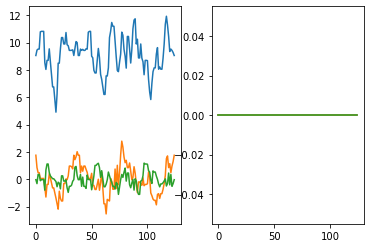

In [21]:
show_samples(X_validation, y_validation, n=1, is_random=False)

In [22]:
if USE_BRYAN_VALIDATION_DATASET:
    X_test = X_validation
    y_test = y_validation
    y_test_hot = y_validation_hot

Check size

In [23]:
del X_df, y_df

assert X_train.shape[0] == y_train.shape[0], f"Invalid shape for X_train and y_train: {X_train.shape} != {y_train.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

## Data Exploration

### Training Set

In [24]:
print("Users", y_train_df["user"].unique())
print("Models", y_train_df["model"].unique())
print("Classes", y_train_df["label"].unique())

Users ['d' 'f' 'b' 'i' 'h' 'a' 'g' 'c' 'e']
Models ['nexus4_1' 'nexus4_2' 's3_1' 's3_2' 's3mini_1' 's3mini_2']
Classes ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']


Fraction of samples per label

In [25]:
print(y_train_df.groupby(["label"])["label"].count() / y_train_df["label"].count())

label
bike           0.139714
no_activity    0.368941
stairsdown     0.118155
stairsup       0.151445
walk           0.221745
Name: label, dtype: float64


Fraction of samples per user

In [26]:
print(y_train_df.groupby(["user"])["user"].count() / y_train_df["user"].count())

user
a    0.113949
b    0.115366
c    0.101465
d    0.114480
e    0.120413
f    0.094781
g    0.113285
h    0.107353
i    0.118907
Name: user, dtype: float64


Fraction of samples per model

In [27]:
print(y_train_df.groupby(["model"])["model"].count() / y_train_df["model"].count())

model
nexus4_1    0.198105
nexus4_2    0.211342
s3_1        0.187171
s3_2        0.206029
s3mini_1    0.190137
s3mini_2    0.007216
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [28]:
y_df_i = y_train_df.loc[y_train_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

2686
label
bike           0.164557
no_activity    0.380491
stairsdown     0.119509
stairsup       0.099032
walk           0.236411
Name: label, dtype: float64


### Validation Set

In [29]:
print("Classes (validation)", y_validation_df["label"].unique())

Classes (validation) ['bike' 'stairsdown' 'no_activity' 'walk' 'stairsup']


In [30]:
print(y_validation_df.groupby(["label"])["label"].count() / y_validation_df["label"].count())

label
bike           0.264794
no_activity    0.252448
stairsdown     0.106854
stairsup       0.111111
walk           0.264794
Name: label, dtype: float64


In [31]:
print(y_validation_df.groupby(["user"])["user"].count() / y_validation_df["user"].count())

user
a    1.0
Name: user, dtype: float64


In [32]:
print(y_validation_df.groupby(["model"])["model"].count() / y_validation_df["model"].count())

model
oneplus_8t    1.0
Name: model, dtype: float64


## Model (autoencoder)

In [33]:
DATA_SHAPE = X_train.shape[1:]
CODE_SIZE=30

In [34]:
def build_encoder(data_shape, code_size):
    inputs = tf.keras.Input(data_shape)

    X = inputs    
    X = layers.Flatten()(X)
    X = layers.Dense(150, activation="relu")(X)
    X = layers.Dense(code_size, activation="sigmoid")(X)
    outputs = X
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [35]:

def build_decoder(data_shape, code_size):
    inputs = tf.keras.Input((code_size,))

    X = inputs
    X = layers.Dense(150, activation="relu")(X)
    X = layers.Dense(np.prod(data_shape), activation=None)(X)
    outputs = layers.Reshape(data_shape)(X)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [36]:
def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(DATA_SHAPE)  # input
    codes = encoder(inputs)              # build the code with the encoder
    outputs = decoder(codes)             # reconstruction the signal with the decoder

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [37]:
encoder = build_encoder(DATA_SHAPE, CODE_SIZE)
decoder = build_decoder(DATA_SHAPE, CODE_SIZE)

In [38]:
autoencoder = build_autoencoder(encoder, decoder)

optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=200
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
save_model_checkpoint_callback = ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

autoencoder.compile(optimizer=optimizer, loss=loss)

history = autoencoder.fit(
    x=X_train, y=X_train, 
    epochs=epochs, 
    validation_data=(X_test, X_test), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1)

loss: 1.2585
Epoch 6/200
177/177 [==============================] - 1s 3ms/step - loss: 1.2833 - val_loss: 1.1738
Epoch 7/200
177/177 [==============================] - 1s 3ms/step - loss: 1.2386 - val_loss: 1.1402
Epoch 8/200
177/177 [==============================] - 1s 3ms/step - loss: 1.2134 - val_loss: 1.1655
Epoch 9/200
177/177 [==============================] - 1s 3ms/step - loss: 1.1970 - val_loss: 1.1417
Epoch 10/200
177/177 [==============================] - 1s 3ms/step - loss: 1.1882 - val_loss: 1.1257
Epoch 11/200
177/177 [==============================] - 1s 3ms/step - loss: 1.1832 - val_loss: 1.1162
Epoch 12/200
177/177 [==============================] - 1s 3ms/step - loss: 1.1728 - val_loss: 1.1143
Epoch 13/200
177/177 [==============================] - 1s 3ms/step - loss: 1.1425 - val_loss: 1.0915
Epoch 14/200
177/177 [==============================] - 1s 3ms/step - loss: 1.0824 - val_loss: 1.0508
Epoch 15/200
177/177 [==============================] - 1s 3ms/step - los

In [39]:
encoder.save("encoder.h5")

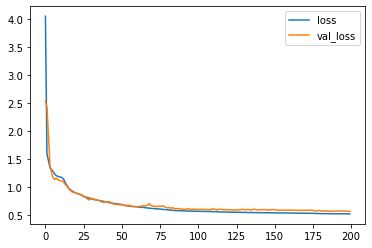

In [40]:
show_loss(history)

In [41]:
show_mse(autoencoder, X_test)

MSE = 0.5708220601081848


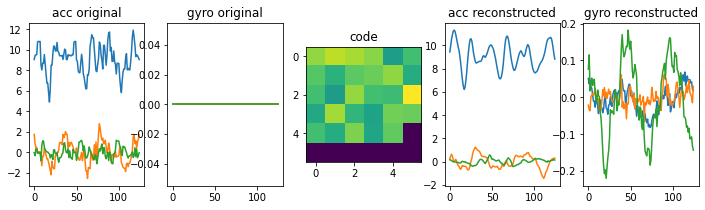

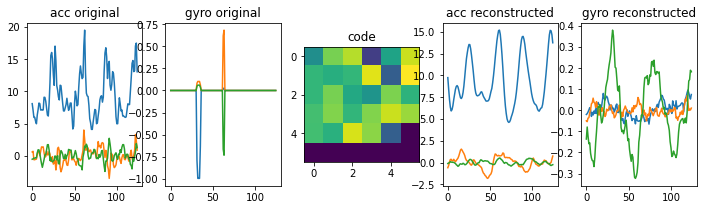

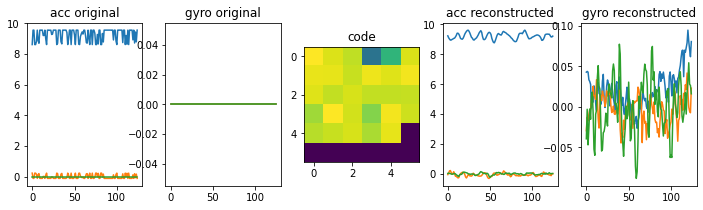

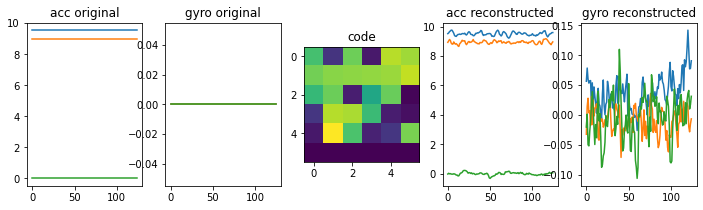

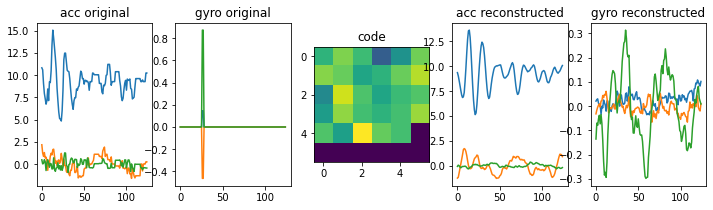

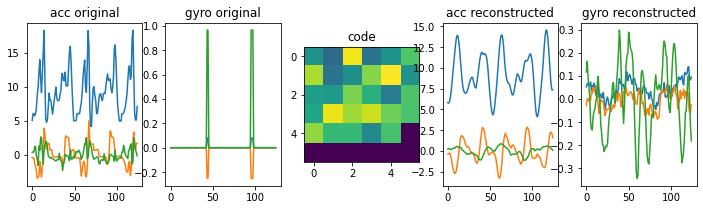

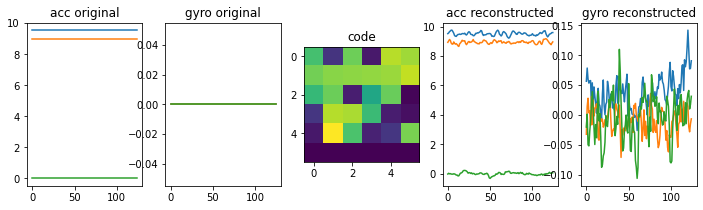

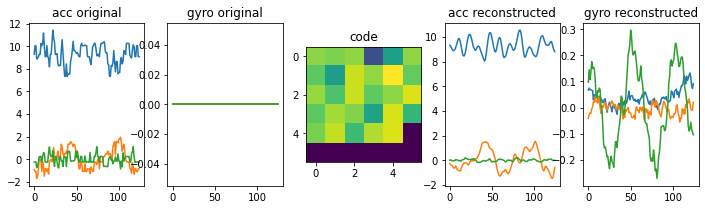

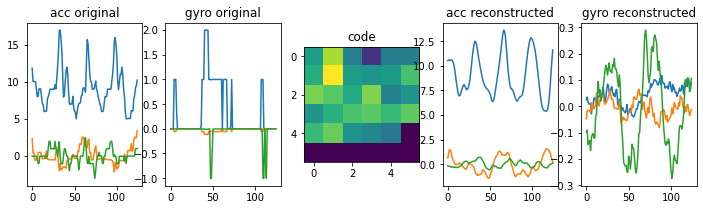

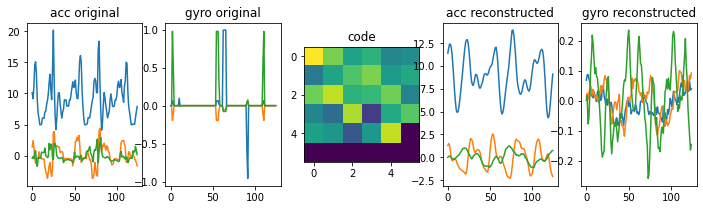

In [42]:
show_reconstructed_signals(X_test, encoder, decoder, n=10)

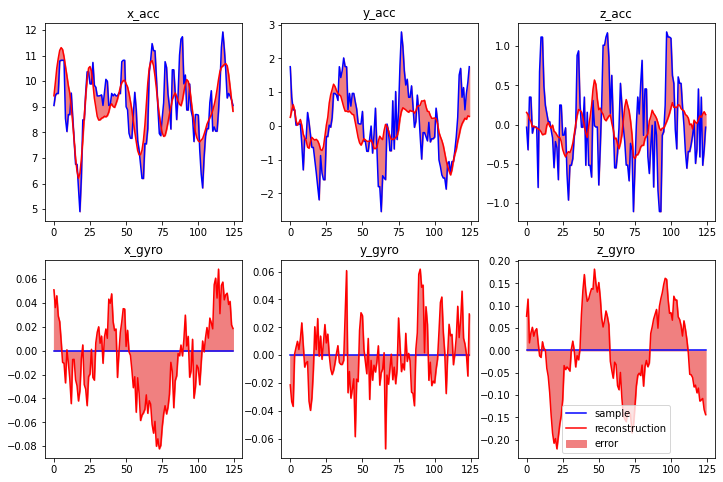

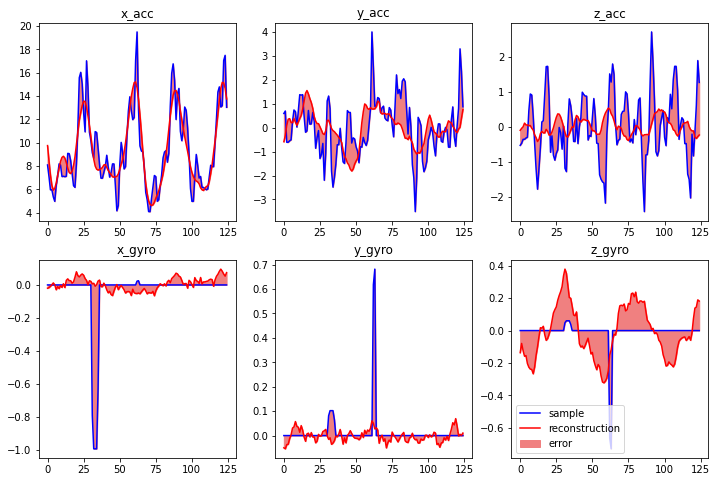

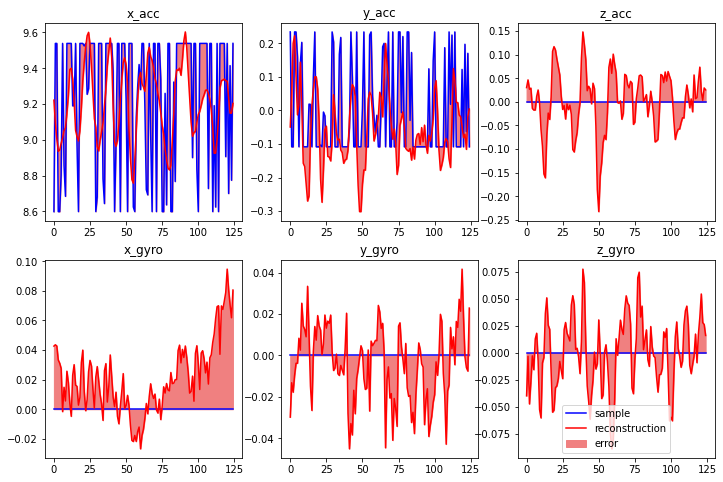

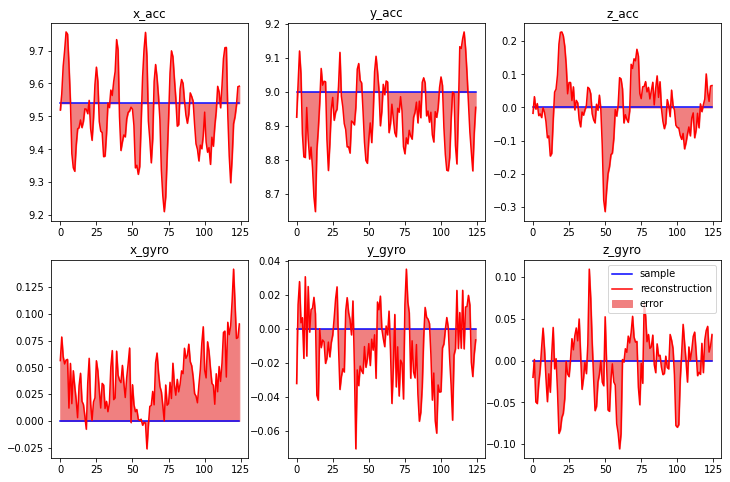

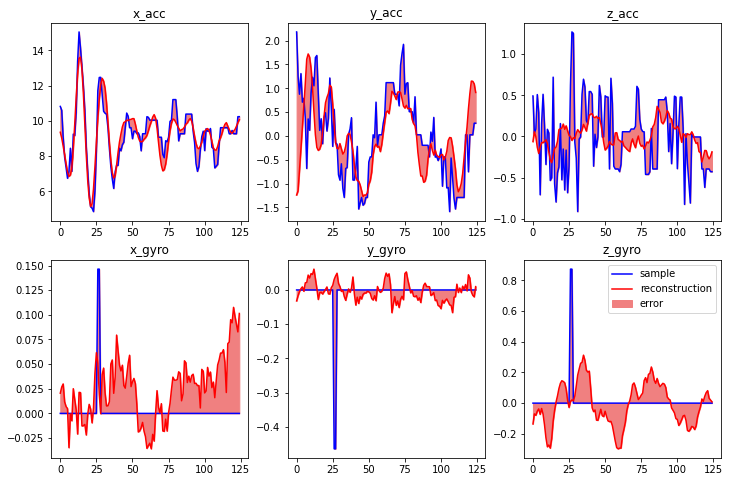

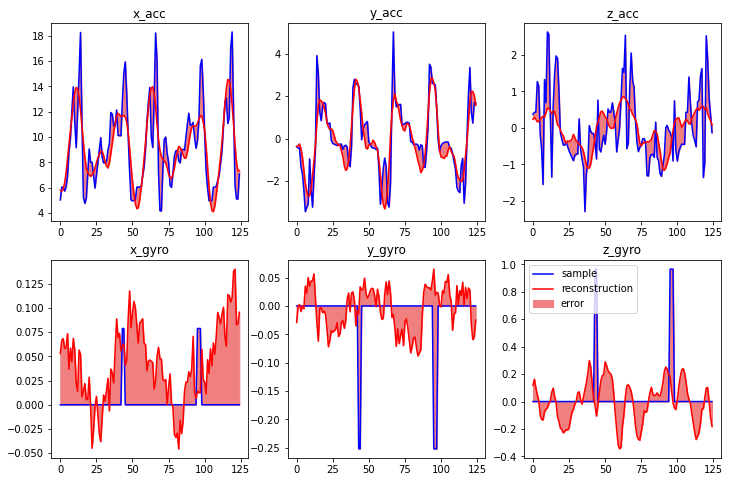

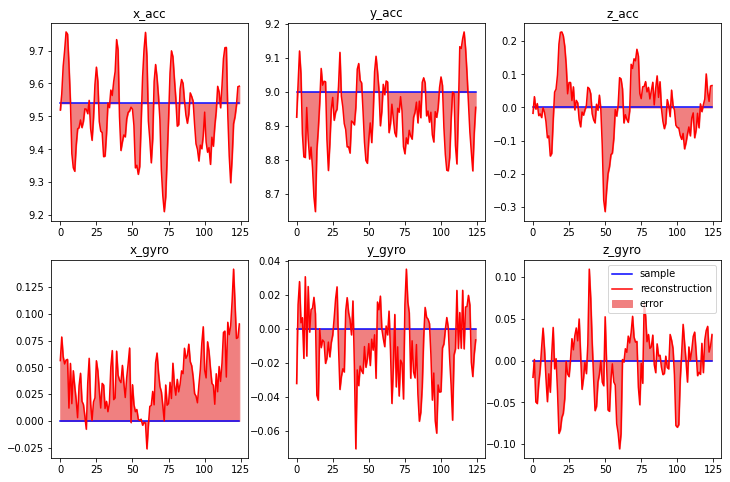

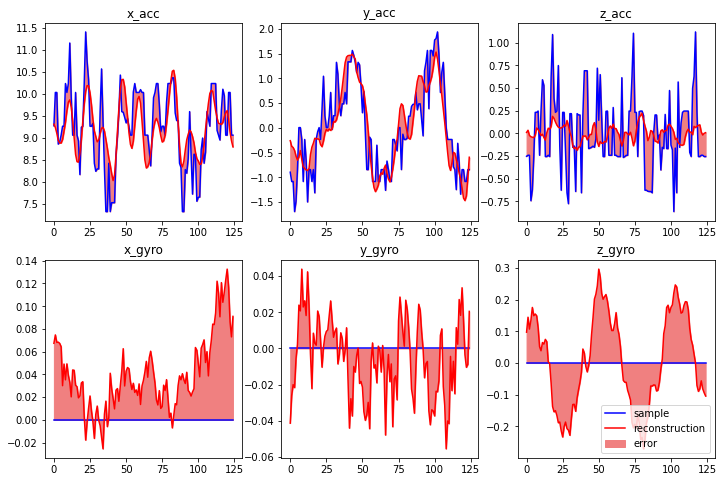

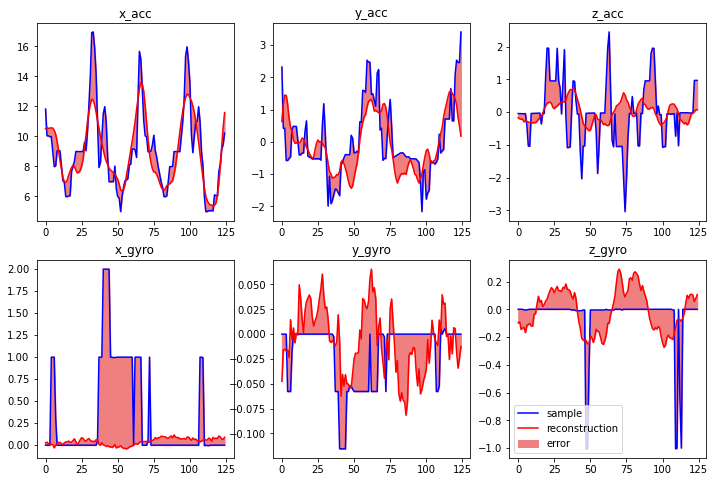

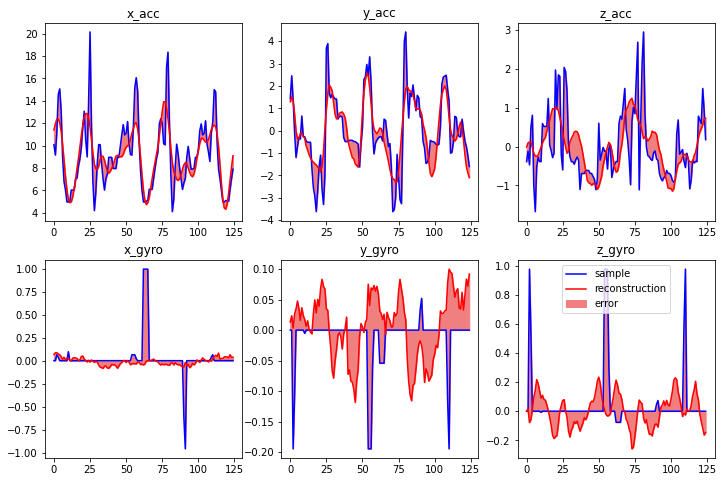

In [43]:
show_reconstruction_errors(X_test, encoder, decoder, n=10)

## KNN classifier

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# prepare the codes
codes = encoder.predict(X_train)

assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"

# create the k-neighbors calssifier
n_neighbors = num_classes
metric = "euclidean"

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

# fit the model using the codes
nbrs.fit(codes, y_train)

KNeighborsClassifier(metric='euclidean')

In [45]:
print("Classes =", nbrs.classes_)

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']


In [46]:
print("X_test[i] = y_true \t y_pred    \t with probs [...]")
print()

for i in range(20):
    x = X_test[i]
    y = y_test[i]

    c = encoder.predict(x[np.newaxis, :])[0]
    
    [lab] = nbrs.predict(c[np.newaxis, :])
    [probs] = nbrs.predict_proba(c[np.newaxis, :])

    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")


X_test[i] = y_true 	 y_pred    	 with probs [...]

X_test[0] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[1] = stairsdown	 stairsdown   	 with probs [0. 0. 1. 0. 0.]
X_test[2] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[3] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[4] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[5] = walk	 walk   	 with probs [0. 0. 0. 0. 1.]
X_test[6] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[7] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[8] = stairsup	 stairsup   	 with probs [0.  0.  0.4 0.6 0. ]
X_test[9] = walk	 walk   	 with probs [0.  0.  0.  0.2 0.8]
X_test[10] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[11] = walk	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[12] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[13] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[14] = walk	 walk   	 with probs [0. 0. 0. 0. 1.]
X_test[15] = bike	 bike   	 with 

In [47]:
from sklearn.metrics import classification_report

codes = encoder.predict(X_test)

y_true = y_test
y_pred = nbrs.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.71      0.97      0.82       622
 no_activity       0.97      0.99      0.98       593
  stairsdown       0.82      0.90      0.86       251
    stairsup       0.57      0.80      0.67       261
        walk       0.98      0.41      0.58       622

    accuracy                           0.80      2349
   macro avg       0.81      0.81      0.78      2349
weighted avg       0.84      0.80      0.78      2349



## KMeans classifier

In [48]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
le.fit(y_test)

# train
codes = encoder.predict(X_train)

kmeans = KMeans(n_clusters=num_classes, random_state=0)
kmeans.fit(codes)

# evaluate 
codes = encoder.predict(X_test)

y_true = y_test
y_pred = le.inverse_transform(kmeans.predict(codes))

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.15      0.05      0.08       622
 no_activity       0.20      0.51      0.29       593
  stairsdown       0.19      0.24      0.21       251
    stairsup       0.00      0.00      0.00       261
        walk       0.00      0.00      0.00       622

    accuracy                           0.17      2349
   macro avg       0.11      0.16      0.12      2349
weighted avg       0.11      0.17      0.12      2349



## NN classifier

In [49]:
def build_nn(code_size):
    inputs = tf.keras.Input((code_size,))
    X = inputs
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(num_classes, activation="softmax")(X)
    outputs = X

    return tf.keras.Model(inputs=inputs, outputs=outputs)


codes_train = encoder.predict(X_train)
codes_test = encoder.predict(X_test)

nn_model = build_nn(CODE_SIZE)

adam_optimizer = tf.keras.optimizers.Adam()
loss_funct = tf.keras.losses.CategoricalCrossentropy()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks = [early_stopping_callback]

nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])
nn_model.summary()

history = nn_model.fit(x=codes_train, y=y_train_hot,
    epochs=50,
    validation_data=(codes_test, y_test_hot), 
    batch_size=128,
    callbacks=callbacks,
    verbose=1)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 13,705
Trainable params: 13,705
Non-trainable params: 0
__________________________________________________

74/74 [==============================] - 0s 705us/step - loss: 0.6375 - accuracy: 0.7616
LOSS = 0.6374551057815552
ACCURACY = 0.7616006731987


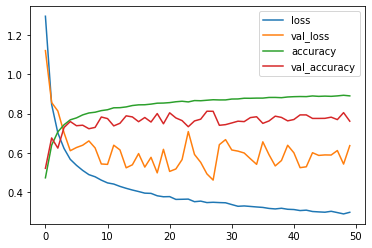

In [50]:
from sklearn.metrics import accuracy_score

loss, accuracy = nn_model.evaluate(codes_test, y_test_hot)

print("LOSS =", loss)
print("ACCURACY =", accuracy)

show_loss(history)

# Grid Search


We are searching for best hyperparams. More precisely we want to find the best autoencoder model given

* code size
* optimizer
* loss func
* epochs
* batch size

In [51]:
def get_filename(hparams):
    return f'models/encoder{get_settings()}_cs-{hparams["code_size"]}_loss-{hparams["loss_func"]}_bs-{hparams["batch_size"]}.h5'

def compile_autoencoder(autoencoder, hparams):
    """
    Compile autoencoder with given hyperparams.
    """

    optimizer = hparams["optimizer"]
    loss = hparams["loss_func"]

    autoencoder.compile(optimizer=optimizer, loss=loss)

    return autoencoder


def fit_autoencoder(autoencoder, hparams):
    """
    Fit the autoencoder with given hyperparams on `X_train` with validation `X_test`.
    Please note that the best and last models are saved in `models` folder.
    """

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    callbacks = [early_stopping_callback]

    history = autoencoder.fit(
        x=X_train, y=X_train, 
        epochs=hparams["epochs"], 
        validation_data=(X_test, X_test), 
        batch_size=hparams["batch_size"],
        callbacks=callbacks,
        verbose=0)

    return history


def evaluate_autoencoder(autoencoder):
    """
    Evaluate the autoencoder with `X_test`.
    """
    return autoencoder.evaluate(X_test, X_test, verbose=0)


def run_model(hparams):
    """
    Setup, train and evaluate the autoencoder model with given hyperparams.

    :return: A tuple `(loss, hystory)`
    """
    encoder = build_encoder(DATA_SHAPE, hparams["code_size"])
    decoder = build_decoder(DATA_SHAPE, hparams["code_size"])

    autoencoder = build_autoencoder(encoder, decoder)
    autoencoder = compile_autoencoder(autoencoder, hparams)

    history = fit_autoencoder(autoencoder, hparams)
    loss = evaluate_autoencoder(autoencoder)

    # Note: we may also add the classifier training and evaluation 
    #       to select the best model

    filepath = get_filename(hparams)
    encoder.save(filepath)

    return loss, history


def select_model():
    """
    Run the model with hyperparams and save results.

    :return: An array of results with mse, hparams and training history.
    """
    results = []

    hparams_code_sizes = [6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 72]
    hparams_opts = ["adam"]
    hparams_losses = ["mse"]
    hparams_epochs = [150]
    hparams_batch_sizes = [32, 128]

    n_iterations = np.prod([len(hparams_code_sizes), len(hparams_opts), len(hparams_losses), len(hparams_epochs), len(hparams_batch_sizes)])

    print(f"Starting model selection... {n_iterations} iterations needed.") 

    for code_size in hparams_code_sizes:
        for opt in hparams_opts:
            for loss in hparams_losses:
                for epochs in hparams_epochs:
                    for batch_size in hparams_batch_sizes:

                        hparams = {
                            "code_size": code_size,
                            "optimizer": opt,
                            "loss_func": loss,
                            "epochs": epochs,
                            "batch_size": batch_size
                        }

                        print(f"Starting run {len(results)}")
                    
                        loss_val, history = run_model(hparams)

                        print(f"hparams = {hparams}")
                        print(f"{loss} = {loss_val}")
                        print()

                        results += [{"hparams": hparams, "loss_val": loss_val, "history": history}]

    return results

Select the best model based on lowest loss.

In [52]:
import time

results = []

if USE_GRID_SEARCH:
    start = time.time()
    results = select_model()
    end = time.time()

    print(f"Done in {end - start} s")

Starting model selection... 44 iterations needed.
Starting run 0
hparams = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
mse = 2.5591559410095215

Starting run 1
hparams = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
mse = 2.5536556243896484

Starting run 2
hparams = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mae', 'epochs': 150, 'batch_size': 32}
mae = 0.6468190550804138

Starting run 3
hparams = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mae', 'epochs': 150, 'batch_size': 128}
mae = 0.6473158597946167

Starting run 4
hparams = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
mse = 2.5579943656921387

Starting run 5
hparams = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
mse = 2.56889009475708

Starting run 6
hparams = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mae', 'epochs': 1

Print a CSV table for models and save them to file

In [54]:
def get_csv(results):
    if ():
        return ""
    
    s = ",".join(["i", "type", "loss_val"] + [k for k,_ in results[0]["hparams"].items()] + ["filepath"]) + "\n"
    
    for i, result in zip(range(len(results)), results):
        hparams = result["hparams"]
        code_size = hparams["code_size"]
        batch_size = hparams["batch_size"]
        loss_val = result["loss_val"]

        filepath = get_filename(hparams)
        type = get_settings().lstrip("_") if get_settings() != "" else "default"

        s += ",".join([str(i), type, str(loss_val)] + [str(v) for _,v in hparams.items()] + [filepath]) + "\n"
    
    return s


def save_results(results, filename=f'models/res{get_settings()}.csv.txt'):
    with open(filename, mode="w+") as f:
        content = get_csv(results)
        f.write(content)

if len(results) > 0:
    print(get_csv(results))

    if USE_GRID_SEARCH:
        save_results(results)
    else:
        print("WARNING: Results were not saved to file.")

i,type,loss_val,code_size,optimizer,loss_func,epochs,batch_size,filepath
0,oit_bryan,2.5591559410095215,6,adam,mse,150,32,models/encoder_oit_bryan_cs-6_loss-mse_bs-32.h5
1,oit_bryan,2.5536556243896484,6,adam,mse,150,128,models/encoder_oit_bryan_cs-6_loss-mse_bs-128.h5
2,oit_bryan,0.6468190550804138,6,adam,mae,150,32,models/encoder_oit_bryan_cs-6_loss-mae_bs-32.h5
3,oit_bryan,0.6473158597946167,6,adam,mae,150,128,models/encoder_oit_bryan_cs-6_loss-mae_bs-128.h5
4,oit_bryan,2.5579943656921387,12,adam,mse,150,32,models/encoder_oit_bryan_cs-12_loss-mse_bs-32.h5
5,oit_bryan,2.56889009475708,12,adam,mse,150,128,models/encoder_oit_bryan_cs-12_loss-mse_bs-128.h5
6,oit_bryan,0.6488582491874695,12,adam,mae,150,32,models/encoder_oit_bryan_cs-12_loss-mae_bs-32.h5
7,oit_bryan,0.6579219698905945,12,adam,mae,150,128,models/encoder_oit_bryan_cs-12_loss-mae_bs-128.h5
8,oit_bryan,2.0535151958465576,18,adam,mse,150,32,models/encoder_oit_bryan_cs-18_loss-mse_bs-32.h5
9,oit_bryan,0.9237385392189026,18,adam

Check best model

In [95]:
def test_best_model(best_filename, code_size):
    
    def run_nn(codes_train, codes_test):
        nn_model = build_nn(code_size)

        adam_optimizer = tf.keras.optimizers.Adam()
        loss_funct = tf.keras.losses.CategoricalCrossentropy()

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        callbacks = [early_stopping_callback]

        nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])
        #nn_model.summary()

        history = nn_model.fit(x=codes_train, y=y_train_hot,
            epochs=100,
            validation_data=(codes_test, y_test_hot), 
            batch_size=128,
            callbacks=callbacks,
            verbose=0)

        loss, accuracy = nn_model.evaluate(codes_test, y_test_hot)

        return accuracy, loss

        #show_loss(history)
    

    def run_knn(codes_train, codes_test):
        from sklearn.neighbors import KNeighborsClassifier

        # create the k-neighbors calssifier
        n_neighbors = num_classes
        metric = "euclidean"

        nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

        # fit the model using the codes
        nbrs.fit(codes_train, y_train)

        from sklearn.metrics import mean_squared_error
        from sklearn.metrics import accuracy_score

        y_true = y_test
        y_pred = nbrs.predict(codes_test)

        #loss = mean_squared_error(y_true=y_true, y_pred=y_pred)
        accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)

        return accuracy


    encoder = tf.keras.models.load_model(best_filename, compile=False)
    encoder.compile(optimizer="adam", loss="mse")

    codes_train = encoder.predict(X_train, verbose=0)
    codes_test = encoder.predict(X_test, verbose=0)

    accuracy_knn = run_knn(codes_train, codes_test)
    accuracy_nn, loss_nn = run_nn(codes_train, codes_test)

    return {"accuracy_knn": accuracy_knn, "accuracy_nn": accuracy_nn, "loss_nn": loss_nn }
    

if USE_GRID_SEARCH_VALIDATION:
    validations_df = pd.DataFrame(columns=["accuracy_knn", "accuracy_nn", "loss_nn"])

    res_df = pd.read_csv("./models/res.csv.txt")
    res_oit_df = pd.read_csv("./models/res_oit.csv.txt")

    data_df = res_df.append(res_oit_df, ignore_index=True)
    
    for index, row in data_df.iterrows():
        print(f"Validating model {index} ({row['filepath']})")

        test_res = test_best_model(row["filepath"], row["code_size"])

        validations_df = validations_df.append(pd.DataFrame([{ **{"filepath": row['filepath']}, **test_res }]), ignore_index=True)
    
    print(validations_df)

    validations_df.to_csv("./models/validations.csv")
    print("Done")

Validating model 0 (models/encoder_cs-6_loss-mse_bs-32.h5)
74/74 [==============================] - 0s 598us/step - loss: 1.2888 - accuracy: 0.4751
Validating model 1 (models/encoder_cs-6_loss-mse_bs-128.h5)
74/74 [==============================] - 0s 722us/step - loss: 1.4755 - accuracy: 0.3304
Validating model 2 (models/encoder_cs-6_loss-mae_bs-32.h5)
74/74 [==============================] - 0s 697us/step - loss: 1.5501 - accuracy: 0.2524
Validating model 3 (models/encoder_cs-6_loss-mae_bs-128.h5)
74/74 [==============================] - 0s 667us/step - loss: 1.5451 - accuracy: 0.2524
Validating model 4 (models/encoder_cs-12_loss-mse_bs-32.h5)
74/74 [==============================] - 0s 649us/step - loss: 1.1545 - accuracy: 0.5372
Validating model 5 (models/encoder_cs-12_loss-mse_bs-128.h5)
74/74 [==============================] - 0s 661us/step - loss: 1.5300 - accuracy: 0.3831
Validating model 6 (models/encoder_cs-12_loss-mae_bs-32.h5)
74/74 [==============================] - 0s 664

In [56]:
#fn = "models/encoder_cs-30_loss-mse_bs-128.h5"
#test_best_model(fn, 30)